## Draft: exploring *accessibleAt* property for Trainig Materials in the MarketPlace Dataset 

This notebook discovers wrong URL values (if any) in the *accessibleAt* property for Training Materials. 



#### External libraries and function to download descriptions from the MarketPlace dataset using the API
The following two cells are used to import the external libraries used in this Notebook and to define a function; in the final release of this Notebook this function will be (possibly) optimized and provided as an external library.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
def getMPDescriptions (url, pages):
    mdx = pd.Series(range(1, pages+1))
    df_desc = pd.DataFrame()
    for var in mdx:
        turl = url+str(var)+"&perpage=20"
        df_desc_par=pd.read_json(turl, orient='columns')
        df_desc=df_desc.append(df_desc_par, ignore_index=True)
        
    return (df_desc)

### 1 - Get the the descriptions
The MarketPlace API are used to download the descriptions of Trainig Materials

In [27]:
df_tm_all = pd.DataFrame()
df_tm_all =getMPDescriptions ("https://sshoc-marketplace-api.acdh-dev.oeaw.ac.at/api/training-materials?page=", 8)
df_tm_all.index

RangeIndex(start=0, stop=140, step=1)

#### A quick look at data
The table below shows information about few, randomly chosen, descriptions.  
Only a subset of values are shown, in particular: *id, category, label, licenses, contributors, accessibleAt, sourceItemId*.  

In [29]:
df_tm_flat = pd.json_normalize(df_tm_all['trainingMaterials'])
#df_publication_flat.info()
df_tm_work=df_tm_flat[['id', 'category', 'label', 'licenses', 'contributors', 'accessibleAt', 'sourceItemId']]
df_tm_work.head()

,id,category,label,licenses,contributors,accessibleAt,sourceItemId
0,27999,training-material,2.1 Error rates and ground truth - Text Digiti...,[],[],[https://sites.google.com/site/textdigitisatio...,TNK9BG7F
1,11515,training-material,3DHOP - How To,[],[],[http://vcg.isti.cnr.it/3dhop/howto.php],7R4HUMWW
2,28434,training-material,3ds Max Tutorials: Introduction,[],[],[http://docs.autodesk.com/3DSMAX/16/ENU/3ds-Ma...,CNRNDTHT
3,28014,training-material,8 Transcriptions of Speech - The TEI Guidelines,[],[],[http://www.tei-c.org/release/doc/tei-p5-doc/f...,MGAJZAUQ
4,28515,training-material,"Agisoft PhotoScan. Tutorials, beginner level",[],[],[http://www.agisoft.com],F4ZNGB66


### 2 - Check values in *accessibleAT*
A dataframe with three columns: *id, label, AccessibleAt* (see table below for example) is created.

In [54]:
df_tm_work=df_tm_work[['id','label','accessibleAt']]
df_tm_work.sort_values('accessibleAt').tail()

,id,label,accessibleAt
23,27969,CloudCompare - Tutorials Youtube,https://www.youtube.com/playlist?list=PLBNUxsU...
86,27948,MeshLab - Tutorials Youtube,https://www.youtube.com/user/MrPMeshLabTutorials
100,27906,Random Forests for Segmentation and Classifica...,https://www.youtube.com/watch?v=sKf7eaEQfzY
14,29145,Blender Intermediate UV Unwrapping Tutorial,https://www.youtube.com/watch?v=scPSP_U858k
8,28590,Anonymising Research Data,NaN


#### Check if there are empty values in *accessibleAt*

In [80]:
df_tm_work_emptyurls=df_tm_work[(df_tm_work['accessibleAt'].str.len()==0) | (df_tm_work['accessibleAt'].isnull())]
emptyurldescriptionsn=df_tm_work_emptyurls.count()[0]
print(f'\n There are {emptyurldescriptionsn} training materials descriptions without corresponding accessibleAt URLs\n')


 There are 1 training materials descriptions without corresponding accessibleAt URLs



#### Check the validity of URLs in the *accessibleAt* property using the HTTP Result Status
The code below explicitly execute an http call for every URL, waits for the [Result Status Code](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes)  of the call and then registers the code.  
Depending on connections and server answer times it may take several minutes to process all URLs.  
In the final release of this Notebook this code will be (possibly) optimized and provided as an external library.

In [68]:
df_tm_work=df_tm_work.explode('accessibleAt')

In [48]:
df_tm_work_urls=df_tm_work[df_tm_work['accessibleAt'].str.len()>0]
df_urls=df_tm_work_urls['accessibleAt'].values
df_tm_work_aa_http_status = pd.DataFrame (columns = ['url','status'])
import requests
import re
regex = re.compile(
        r'^(?:http|ftp)s?://' # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|' #domain...
        r'localhost|' #localhost...
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' # ...or ip
        r'(?::\d+)?' # optional port
        r'(?:/?|[/?]\S+)$', re.IGNORECASE)
for var in df_urls:
    if ( var != "" and var!=None and re.match(regex, var)):
        try:
            r =requests.get(var,timeout=8)
            df_tm_work_aa_http_status = df_tm_work_aa_http_status.append({'url': var, 'status': int(r.status_code)}, ignore_index=True)
        except requests.exceptions.ConnectionError:
          #  print(var)
            df_tm_work_aa_http_status = df_tm_work_aa_http_status.append({'url': var, 'status': int(503)}, ignore_index=True)
        except requests.exceptions.ConnectTimeout:
          #  print(var)
            df_tm_work_aa_http_status = df_tm_work_aa_http_status.append({'url': var, 'status': int(408)}, ignore_index=True)
        except requests.exceptions.ReadTimeout:
         #   print(var)
            df_tm_work_aa_http_status = df_tm_work_aa_http_status.append({'url': var, 'status': int(408)}, ignore_index=True)
        except requests.exceptions.RequestException:
         #   print(var)
            df_tm_work_aa_http_status = df_tm_work_aa_http_status.append({'url': var, 'status': int(500)}, ignore_index=True)
        except TypeError:
        #    print(var)
            df_tm_work_aa_http_status = df_tm_work_aa_http_status.append({'url': var, 'status': int(400)}, ignore_index=True)
    else:
       # print(var ,0)
        df_tm_work_aa_http_status = df_tm_work_aa_http_status.append({'url': var, 'status': int(400)}, ignore_index=True)
#df_publication_work_aa_http_status.head()

In [49]:
df_tm_work_aa_http_status.count()

url       141
status    141
dtype: int64

In [50]:
df_http_status_sub=df_tm_work_aa_http_status[df_tm_work_aa_http_status['status'] != 1]
df_db_st = df_http_status_sub['status'].value_counts()
print('{:<8}Frequency'.format("Status"))
df_db_st.head(10)

Status  Frequency


200    132
404      5
403      2
503      1
406      1
Name: status, dtype: int64

The first column in the table above shows the HTTP Status codes obtained when trying to connect on *accessibleAt* URLs, the second column the total number of URLs returning the status.
Notice that while 404 means that the resource is not found, other status codes may indicate temporary problems.  
The image below summarizes of the above result.

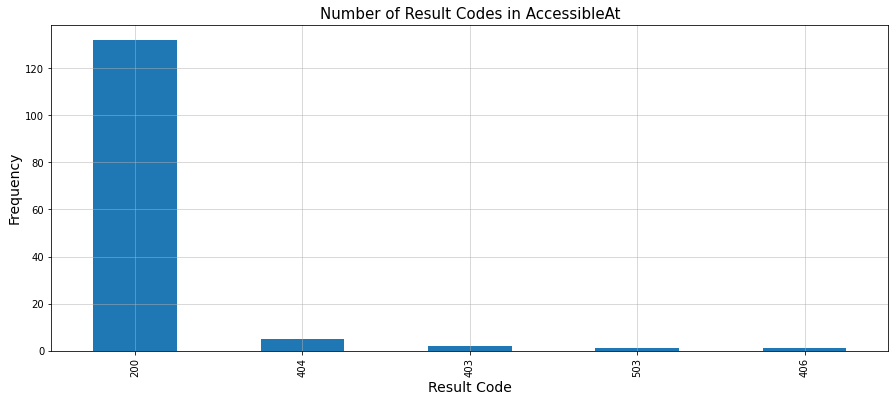

In [51]:
fig, ax = plt.subplots()
df_db_st.plot(kind='bar', figsize=(15,6), x='Status', y='Frequency',)
plt.grid(alpha=0.6)
ax.yaxis.set_label_text("")
ax.set_title("Number of Result Codes in AccessibleAt", fontsize=15)
ax.set_xlabel('Result Code', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14);
plt.show()

### 3 - Save results
The list of possibly wrong URLs is saved in a Comma Separated Values (CSV) file having the following columns: *id, label, url, status*. The final release of this notebook will save this data in the curation dataset.

In [52]:
df_http_status_err=df_http_status_sub[df_http_status_sub['status'] != 200]
df_list_of_tm_wrongaa=pd.merge(left=df_publication_work, right=df_http_status_err, left_on='accessibleAt', right_on='url')
df_list_of_tm_wrongaa.head()
df_list_of_tm_wrongaa[['id', 'label', 'url', 'status']].sort_values('id').to_csv(path_or_buf='trainingmaterials_wrongurls.csv')